In [ ]:
!apt-get update
!apt install -y python3-opengl ffmpeg xvfb
!pip install -q stable-baselines3[extra] highway-env moviepy gymnasium

import gymnasium as gym
import highway_env
from stable_baselines3 import PPO
from stable_baselines3.common.vec_env import DummyVecEnv
import numpy as np
import matplotlib.pyplot as plt

Get:1 https://cloud.r-project.org/bin/linux/ubuntu jammy-cran40/ InRelease [3,632 B]
Get:2 http://security.ubuntu.com/ubuntu jammy-security InRelease [129 kB]
Hit:3 http://archive.ubuntu.com/ubuntu jammy InRelease
Get:4 http://archive.ubuntu.com/ubuntu jammy-updates InRelease [128 kB]
Hit:5 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu2204/x86_64  InRelease
Get:6 https://ppa.launchpadcontent.net/deadsnakes/ppa/ubuntu jammy InRelease [18.1 kB]
Get:7 https://r2u.stat.illinois.edu/ubuntu jammy InRelease [6,555 B]
Hit:8 https://ppa.launchpadcontent.net/graphics-drivers/ppa/ubuntu jammy InRelease
Get:9 https://r2u.stat.illinois.edu/ubuntu jammy/main all Packages [9,086 kB]
Hit:10 https://ppa.launchpadcontent.net/ubuntugis/ppa/ubuntu jammy InRelease
Get:11 http://security.ubuntu.com/ubuntu jammy-security/restricted amd64 Packages [4,780 kB]
Get:12 http://archive.ubuntu.com/ubuntu jammy-backports InRelease [127 kB]
Get:13 http://archive.ubuntu.com/ubuntu jammy-updates/restri

In [ ]:
import gymnasium as gym
import highway_env

# Correct way to initialize for rendering in Colab
env = gym.make("highway-v0")
obs, _ = env.reset()
frame = env.render()  # Now won't give a warning

/usr/local/lib/python3.11/dist-packages/highway_env/envs/common/abstract.py:292: UserWarning: WARN: You are calling render method without specifying any render mode. You can specify the render_mode at initialization, e.g. gym.make("highway-v0", render_mode="rgb_array")
  gym.logger.warn(


In [ ]:
print("Observation Space:", env.observation_space)
print("Action Space:", env.action_space)

Observation Space: Box(-inf, inf, (5, 5), float32)
Action Space: Discrete(5)


In [ ]:
from stable_baselines3.common.monitor import Monitor

# Vectorized environment
env = DummyVecEnv([lambda: Monitor(gym.make("highway-v0"))])

model = PPO("MlpPolicy", env, verbose=1, tensorboard_log="./ppo_highway_tensorboard/")
model.learn(total_timesteps=10000)
model.save("ppo_highway")

Using cpu device
Logging to ./ppo_highway_tensorboard/PPO_2
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 13.8     |
|    ep_rew_mean     | 10.5     |
| time/              |          |
|    fps             | 2        |
|    iterations      | 1        |
|    time_elapsed    | 989      |
|    total_timesteps | 2048     |
---------------------------------
-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 18.1        |
|    ep_rew_mean          | 13.4        |
| time/                   |             |
|    fps                  | 2           |
|    iterations           | 2           |
|    time_elapsed         | 1977        |
|    total_timesteps      | 4096        |
| train/                  |             |
|    approx_kl            | 0.014352631 |
|    clip_fraction        | 0.182       |
|    clip_range           | 0.2         |
|    entropy_loss         | -1.6        |
|    explain

In [ ]:
model.save("/content/drive/MyDrive/ppo_highway")

In [ ]:
from stable_baselines3.common.evaluation import evaluate_policy
from moviepy.editor import ImageSequenceClip
import os

eval_env = gym.make("highway-v0", render_mode="rgb_array")
obs, _ = eval_env.reset()
images = []

for _ in range(200):
    action, _ = model.predict(obs, deterministic=True)
    obs, reward, done, truncated, info = eval_env.step(action)
    frame = eval_env.render()
    images.append(frame)
    if done or truncated:
        obs, _ = eval_env.reset()

# Save video
clip = ImageSequenceClip(images, fps=30)
clip.write_videofile("highway_eval.mp4")

/usr/local/lib/python3.11/dist-packages/moviepy/config_defaults.py:1: DeprecationWarning: invalid escape sequence '\P'
  """
/usr/local/lib/python3.11/dist-packages/moviepy/video/io/ffmpeg_reader.py:294: DeprecationWarning: invalid escape sequence '\d'
  lines_video = [l for l in lines if ' Video: ' in l and re.search('\d+x\d+', l)]
  from scipy.ndimage.filters import sobel

  if event.key is 'enter':



Moviepy - Building video highway_eval.mp4.
Moviepy - Writing video highway_eval.mp4



Moviepy - Done !
Moviepy - video ready highway_eval.mp4


In [ ]:
custom_config = {
    "lanes_count": 3,
    "vehicles_count": 30,
    "duration": 40,
    "policy_frequency": 15
}
custom_env = gym.make("highway-v0", render_mode="rgb_array", config=custom_config)
custom_env.reset()

(array([[ 1.        ,  1.        ,  0.33333334,  0.3125    ,  0.        ],
        [ 1.        ,  0.12051602,  0.        , -0.04098373,  0.        ],
        [ 1.        ,  0.22463411,  0.        , -0.04245656,  0.        ],
        [ 1.        ,  0.34156522,  0.33333334, -0.04156457,  0.        ],
        [ 1.        ,  0.46176812,  0.33333334, -0.0485418 ,  0.        ]],
       dtype=float32),
 {'speed': 25,
  'crashed': False,
  'action': np.int64(1),
  'rewards': {'collision_reward': 0.0,
   'right_lane_reward': 0.5,
   'high_speed_reward': np.float64(0.5),
   'on_road_reward': 1.0}})

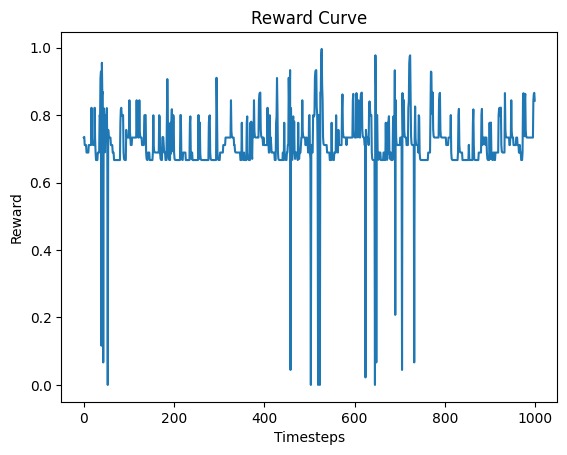

In [ ]:
rewards = []
eval_env = gym.make("highway-v0")
obs, _ = eval_env.reset()

for _ in range(1000):
    action, _ = model.predict(obs)
    obs, reward, done, truncated, _ = eval_env.step(action)
    rewards.append(reward)
    if done or truncated:
        obs, _ = eval_env.reset()

import matplotlib.pyplot as plt
plt.plot(rewards)
plt.title("Reward Curve")
plt.xlabel("Timesteps")
plt.ylabel("Reward")
plt.show()

In [ ]:
from stable_baselines3.common.monitor import Monitor

custom_config = {
    "lanes_count": 3,
    "vehicles_count": 30,
    "duration": 40,
    "policy_frequency": 15
}

base_env = gym.make("highway-v0", config=custom_config)
monitored_env = Monitor(base_env)


In [ ]:
from stable_baselines3.common.evaluation import evaluate_policy

mean_reward, std_reward = evaluate_policy(model, custom_env, n_eval_episodes=10, deterministic=True)
print(f"Mean reward: {mean_reward:.2f}, Std: {std_reward:.2f}")

Mean reward: 427.07, Std: 15.62
